This notebook shows an example of the semantic segmentation done by a deep learning model called Unet.

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model


import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd

### Loading dataset

Explore dataset: [oxford_iiit_pet](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [15]:
# Information about the dataset
print(info)
print(dataset)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

#### Preprocessing dataset

In [4]:
def resize(input_image, input_mask, image_size=(112, 112)):
  """ Function to resize an image
  Args:
    input_image (np.array):      image to resize
    input_mask (np.array):       GT of the image (same size of input_image)
    image_size (tuple):          new with and height of the output image
  """
  input_image = tf.image.resize(input_image, image_size, method="nearest")
  input_mask = tf.image.resize(input_mask, image_size, method="nearest")
  return input_image, input_mask

def normalize(input_image, input_mask):
  """ Function to normalize an image to [0,1] range
  Args:
    input_image (np.array):      image to resize
    input_mask (np.array):       GT of the image (same size of input_image)
  """
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask < 2, tf.float32)
  return input_image, input_mask


In [5]:
def process_image(data):
  """ Function to preprocess (resize, normalize) images and masks
  Args:
    data (Dict):      It contains images and masks
  """

  input_image = data["image"]
  input_mask = data["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [6]:
# It applies the process (resize and normalization to all dataset)
train_dataset = dataset["train"].map(process_image)
test_dataset = dataset["test"].map(process_image)

In [7]:
print(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(112, 112, 1), dtype=tf.float32, name=None))>


In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

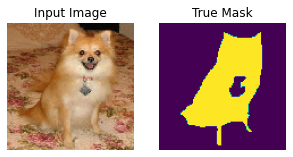

In [9]:
def display(display_list):
  plt.figure(figsize=(5, 5))
  title = ["Input Image", "True Mask", "Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [10]:
def dice_coef(y_true, y_pred, smooth=1.0):
  """Return dice coefficient function between actual and
  predicted label."""
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + 
                                           K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  """Return dice coefficient loss function between actual and
  predicted label."""
  return -dice_coef(y_true, y_pred)


def get_unet(image_size, n_classes, n_channels):
  """Get UNET neural network model.
    Args:
    patch_size (int): Size of patch of the images.
    n_classes (int): Number of classes of the output.
    n_channels (int): Number of channels of the image.
    Returns:
    model: unet model.
  """
  inputs = Input((image_size, image_size, n_channels))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), 
                                       padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), 
                                       padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    
  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), 
                                       padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), 
                                       padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
  conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=conv10)
  return model

In [11]:
model = get_unet(image_size=112, n_classes=1, n_channels=3)

model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, 
              metrics=[dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

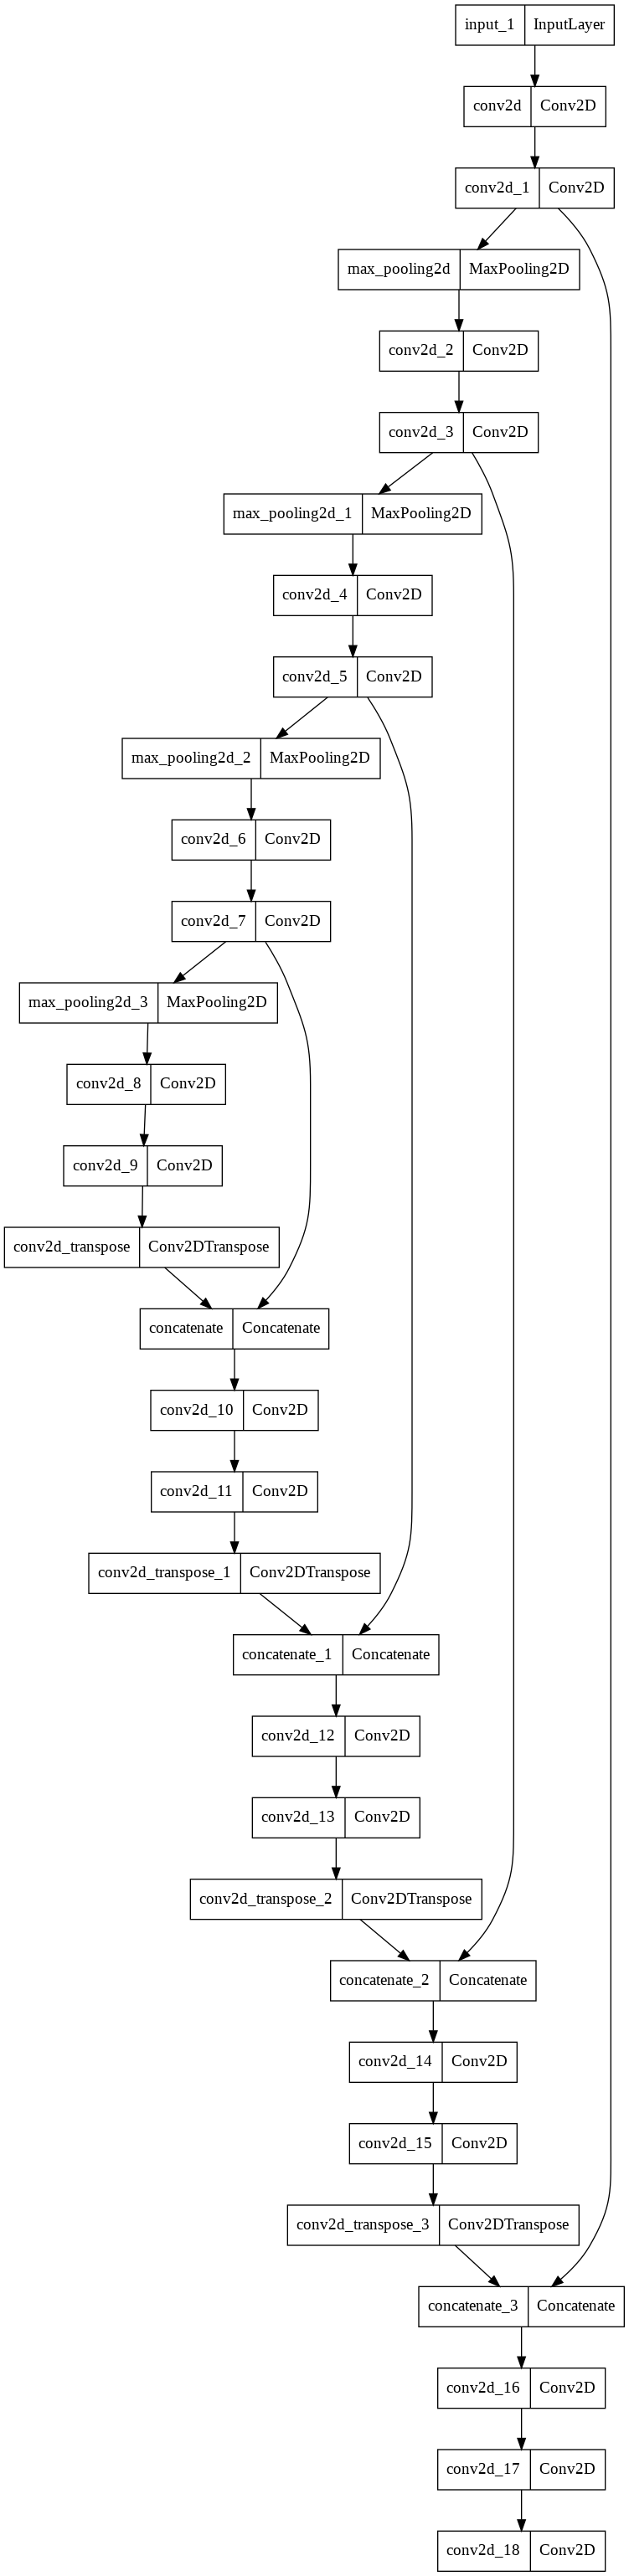

In [21]:
plot_model(model)

In [ ]:
# Download pretrained model
! wget --no-check-certificate 'https://www.dropbox.com/s/zwwkmob7lwirq82/unet_oxford.h5'
# Download info about training
! wget --no-check-certificate  'https://www.dropbox.com/s/c48fvprh98fef30/training.log'

In [72]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = 11

tf.random.set_seed(5)

MODEL_NAME = 'unet_oxford.h5'

# Every epoch the model is saved only the the val_loss is smaller that 
# the previous epoch
checkpoint = ModelCheckpoint(filepath=MODEL_NAME, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min') 
csv_logger = CSVLogger('training.log')

if not os.path.exists(MODEL_NAME):
  model.fit(train_batches, epochs=NUM_EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_steps=VALIDATION_STEPS,
            validation_data=test_batches,
            callbacks=[checkpoint, csv_logger])
else:
  model = load_model(MODEL_NAME, 
                     custom_objects={'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef})

In [59]:
df = pd.read_csv('training.log')
df.head()

,epoch,dice_coef,loss,val_dice_coef,val_loss
0,0,0.423142,-0.423142,0.471461,-0.472320
1,1,0.591026,-0.591652,0.621219,-0.621346
2,2,0.631659,-0.631552,0.626021,-0.626289
3,3,0.642276,-0.642530,0.638411,-0.638956
4,4,0.664966,-0.664826,0.681540,-0.681214


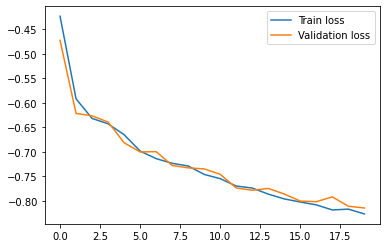

In [63]:
plt.plot(df.epoch, df.loss, label='Train loss')
plt.plot(df.epoch, df.val_loss, label='Validation loss')
plt.legend()
plt.show()

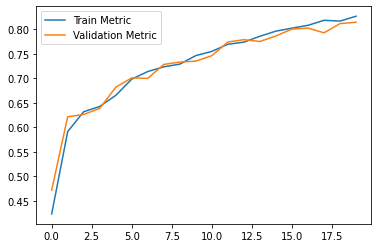

In [64]:
plt.plot(df.epoch, df.dice_coef, label='Train Metric')
plt.plot(df.epoch, df.val_dice_coef, label='Validation Metric')
plt.legend()
plt.show()

Let's see some results on the test set

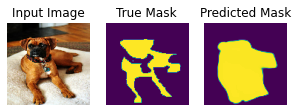

In [58]:
batch = test_batches.take(1)
idx = 10
for image, mask in test_batches.take(1):
  pred_mask = model.predict(image)
  display([image[idx], mask[idx], pred_mask[idx]])